<a href="https://colab.research.google.com/github/Mikcl/CellTransformer/blob/main/Cells_are_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!pip install linear-attention-transformer
!pip install einops

In [43]:
import os
import base64
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from IPython.display import Image, HTML, clear_output
import tqdm

import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import matplotlib.pylab as plt
import glob

import torch.optim as optim

from linear_attention_transformer import LinearAttentionTransformerLM
from linear_attention_transformer.autoregressive_wrapper import AutoregressiveWrapper

from einops import rearrange

clear_output()

In [44]:
#@title Cellular Automata Parameters
CHANNEL_N = 4        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40

# 👁, 🦎
TARGET_EMOJI = "🦎" #@param {type:"string"}

EXPERIMENT_TYPE = "Growing" #@param ["Growing"] # "Persistent", "Regenerating"
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

In [45]:
#@title Transformer Token Details
TOKEN_OFFSET = 2
NUM_TOKENS = 257 + TOKEN_OFFSET
ENC_SEQ_LEN = 9 * CHANNEL_N
DEC_SEQ_LEN = ENC_SEQ_LEN + CHANNEL_N

In [46]:
#@title Tranformer Hyperparameters 

EPOCHS = 10 #int(1e3)
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
# GENERATE_EVERY  = 100   # For visual results during training. . 

In [47]:
#@title Helpers 

def to_rgba(x):
  return x[:,:4,:,:]

def to_rgb(x):
  return x[:,:3,:,:]

def make_seed(size, n=1):
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x

def plot_loss(loss_log):
  plt.figure(figsize=(10, 4))
  plt.title('Loss history (log10)')
  plt.plot(np.log10(loss_log), '.', alpha=0.1)
  plt.show()

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string


In [48]:
#@title Load image utils. 

# Returns h,w,c image where c=RGBA
def load_image(url, max_size=TARGET_SIZE):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  img = np.float32(img)
  return img

def load_emoji(emoji):
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/raw/master/png/128/emoji_u%s.png'%code
  return load_image(url)

In [49]:
#@title To Device
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"
device = torch.device(dev)  

In [50]:
#@title Load Emoji
target_img = load_emoji(TARGET_EMOJI)

In [51]:
p = TARGET_PADDING
target_img_tensor = torch.from_numpy(target_img)

# (72,72,4)
pad_target = torch.nn.functional.pad(target_img_tensor, pad=(0,0,p,p,p,p), mode='constant', value=0)
h, w = pad_target.shape[:2]

# (CHANNEL_N, 72, 72)
seed = np.zeros([CHANNEL_N, h, w], np.float32)
seed[3:, h//2, w//2] = 256

pad_target = pad_target.permute(2, 0, 1)

In [52]:
pad_target = pad_target.to(device)

def loss_f(x):
    x = x[:,:4,:,:]
    return torch.mean(torch.square(x-pad_target), [-1,-2,-3])

In [53]:
#@title Masking Utils
IMAGE_BATCH_SIZE = 1 #number of images to concurrently train on. 
LIVE_MIN = 0

# Applied on default/non-tokenized values
def get_living_mask(x):
  alpha = x[:, 3:4, :, :]
  return torch.nn.functional.max_pool2d(input=alpha, kernel_size=3, stride=1, padding=1) > LIVE_MIN

# 3d tensor as boolean. 
alive_target_mask = get_living_mask(pad_target[None,...])

def get_dilatied_mask(x):
  # Returns x dilated mask as FloatType 
  output = x.sum(-3) > 0
  output = output.type(torch.FloatTensor)
  kernel = torch.tensor([[1,1,1],[1,1,1],[1,1,1]]).type(torch.FloatTensor)
  dilated = torch.nn.functional.conv2d(output[None,...], kernel[None, None, ...].expand(1, -1, -1, -1), groups=1, padding=1)
  return dilated

def get_living_target(x):
  living_mask = get_living_mask(x)

  # print('SUM OF 1s', torch.sum(torch.flatten(living_mask)))
  living_target_mask = (living_mask & alive_target_mask)
  living_target = pad_target[None,...] * living_target_mask.float()
  living_target = living_target[0]
  return living_target

def mask_target(mask):
  '''
    mask - tensor: 2D - Float

    returns - tensor: 4D - T
  '''
  # returns 4d tensor. 
  target_batch = pad_target[None, ...] * mask
  return target_batch


In [54]:
#@title Define Model

def tokenize(x):
  return (x + 2).long()

def detokenize(x):
  return (x - 2).long()

def percieve(x):
  # x - 4d tensor - N, C, H, W
  _,_,h,w = x.shape
  padded_x = torch.nn.functional.pad(x, pad=(1,1,1,1), mode='constant', value=0)
  stacked_image = torch.cat(
      [padded_x[:,:,i:i+h, j:j+w]  for i in range(3) for j in range(3)]
      ,1
  )
  return stacked_image


# instantiate model
enc = LinearAttentionTransformerLM(
    num_tokens = NUM_TOKENS,
    dim = 512,
    heads = 8,
    depth = 1,
    max_seq_len = ENC_SEQ_LEN,
    one_kv_head = True,
    return_embeddings = True
).to(device)

dec = LinearAttentionTransformerLM(
    num_tokens = NUM_TOKENS,
    dim = 512,
    heads = 8,
    depth = 3,
    causal = True,
    blindspot_size = 2,             # a small blindspot greatly saves on memory
    max_seq_len = DEC_SEQ_LEN,
    one_kv_head = True,
    receives_context = True
).to(device)

dec = AutoregressiveWrapper(dec)

# optimizer

optim = torch.optim.Adam([*enc.parameters(), *dec.parameters()], lr=LEARNING_RATE)


In [55]:
#@title Dataset Generation Helpers. 
SENTENCES = int(alive_target_mask.shape[2] * alive_target_mask.shape[3])

class CellTraining(Dataset):
    def __init__(self, X, Y):
        self.src = X
        self.tgt = Y
        assert X.shape[0] == Y.shape[0], 'Dataset X and Y not of same length'
        # assert X.shape[0] == SENTENCES, 'Dataset does not match image'
        b = X.shape[0]
        self.SRC_MASK = torch.ones(b, ENC_SEQ_LEN).bool()
        self.TGT_MASK = torch.ones(b, DEC_SEQ_LEN).bool()

        self.length = b

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        src = self.src[idx]
        tgt = self.tgt[idx]
        src_mask = self.SRC_MASK[idx]
        tgt_mask = self.TGT_MASK[idx] 
        return src.to(device), tgt.to(device), src_mask.to(device), tgt_mask.to(device)


class CellEvaluating(Dataset):
    def __init__(self, X):
        self.src = X
        b = X.shape[0]
        self.SRC_MASK = torch.ones(b, ENC_SEQ_LEN).bool()
        self.length = b

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        src = self.src[idx]
        src_mask = self.SRC_MASK[idx]
        return src.to(device), src_mask.to(device)



def get_start_tokens(number_of_sentences):
    return torch.ones((number_of_sentences, 1)).long().to(device)

def image_to_sentences(x):
  '''
    ## maps a 3D tensor of shape (c, h, w) to a 2D tensor of (h*w, c)
    these are known as sentences or 'patches' of size one
  '''
  return rearrange(x,'c (h p1) (w p2) -> (h w) (p1 p2 c)', p1 = 1, p2 = 1)


def sentences_to_image(x, height, width):
  '''
    ## maps a 2D tesnor of shape (h*w, c) to image/3D tensor shape of (c, h, w)
    inverse of image_to_sentence
    height: int - image dimension
    width: int - image dimension
  '''
  return rearrange(x, '(h w) (p1 p2 c) -> c (h p1) (w p2)', p1 =1, p2 =1, h=height, w=width)


def visualize_batched(x):
  x = x[:,:4,:,:].cpu().numpy()
  vis1 = np.hstack(np.transpose(x, (0,2,3,1)))
  plt.imshow(vis1)
  plt.show()


training:   0%|          | 0/10 [00:00<?, ?it/s]

epoch 0, step 0
epoch 0, step 1
epoch 0, step 2
epoch 0, step 3
epoch 0, step 4
epoch 0, step 5
epoch 0, step 6
epoch 0, step 7
epoch 0, step 8
epoch 0, step 9
epoch 0, step 10
epoch 0, step 11
epoch 0, step 12
epoch 0, step 13
epoch 0, step 14
epoch 0, step 15
epoch 0, step 16
epoch 0, step 17
epoch 0, step 18
epoch 0, step 19
epoch 0, step 20
epoch 0, step 21
epoch 0, step 22
epoch 0, step 23
epoch 0, step 24
epoch 0, step 25
epoch 0, step 26
epoch 0, step 27
epoch 0, step 28
epoch 0, step 29


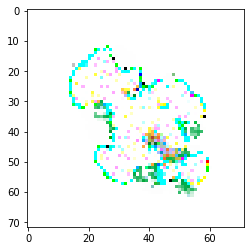

training:  10%|█         | 1/10 [00:53<08:01, 53.49s/it]

epoch 1, step 0
epoch 1, step 1
epoch 1, step 2
epoch 1, step 3
epoch 1, step 4
epoch 1, step 5
epoch 1, step 6
epoch 1, step 7
epoch 1, step 8
epoch 1, step 9
epoch 1, step 10
epoch 1, step 11
epoch 1, step 12
epoch 1, step 13
epoch 1, step 14
epoch 1, step 15
epoch 1, step 16
epoch 1, step 17
epoch 1, step 18
epoch 1, step 19
epoch 1, step 20
epoch 1, step 21
epoch 1, step 22
epoch 1, step 23
epoch 1, step 24
epoch 1, step 25
epoch 1, step 26
epoch 1, step 27
epoch 1, step 28
epoch 1, step 29


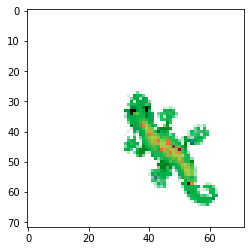

training:  20%|██        | 2/10 [01:45<07:04, 53.04s/it]

epoch 2, step 0
epoch 2, step 1
epoch 2, step 2
epoch 2, step 3
epoch 2, step 4
epoch 2, step 5
epoch 2, step 6
epoch 2, step 7
epoch 2, step 8
epoch 2, step 9
epoch 2, step 10
epoch 2, step 11
epoch 2, step 12
epoch 2, step 13
epoch 2, step 14
epoch 2, step 15
epoch 2, step 16
epoch 2, step 17
epoch 2, step 18
epoch 2, step 19
epoch 2, step 20
epoch 2, step 21
epoch 2, step 22
epoch 2, step 23
epoch 2, step 24
epoch 2, step 25
epoch 2, step 26
epoch 2, step 27
epoch 2, step 28
epoch 2, step 29


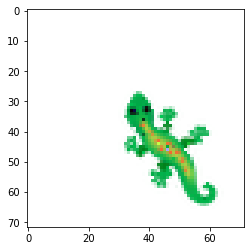

training:  30%|███       | 3/10 [02:38<06:10, 52.91s/it]

epoch 3, step 0
epoch 3, step 1
epoch 3, step 2
epoch 3, step 3
epoch 3, step 4
epoch 3, step 5
epoch 3, step 6
epoch 3, step 7
epoch 3, step 8
epoch 3, step 9
epoch 3, step 10
epoch 3, step 11
epoch 3, step 12
epoch 3, step 13
epoch 3, step 14
epoch 3, step 15
epoch 3, step 16
epoch 3, step 17
epoch 3, step 18
epoch 3, step 19
epoch 3, step 20
epoch 3, step 21
epoch 3, step 22
epoch 3, step 23
epoch 3, step 24
epoch 3, step 25
epoch 3, step 26
epoch 3, step 27
epoch 3, step 28
epoch 3, step 29


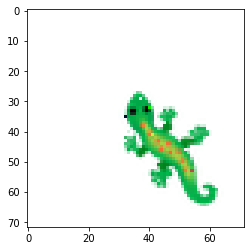

training:  40%|████      | 4/10 [03:30<05:16, 52.77s/it]

epoch 4, step 0
epoch 4, step 1
epoch 4, step 2
epoch 4, step 3
epoch 4, step 4
epoch 4, step 5
epoch 4, step 6
epoch 4, step 7
epoch 4, step 8
epoch 4, step 9
epoch 4, step 10
epoch 4, step 11
epoch 4, step 12
epoch 4, step 13
epoch 4, step 14
epoch 4, step 15
epoch 4, step 16
epoch 4, step 17
epoch 4, step 18
epoch 4, step 19
epoch 4, step 20
epoch 4, step 21
epoch 4, step 22
epoch 4, step 23
epoch 4, step 24
epoch 4, step 25
epoch 4, step 26
epoch 4, step 27
epoch 4, step 28
epoch 4, step 29


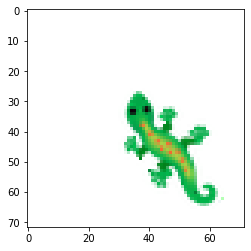

training:  50%|█████     | 5/10 [04:22<04:23, 52.66s/it]

epoch 5, step 0
epoch 5, step 1
epoch 5, step 2
epoch 5, step 3
epoch 5, step 4
epoch 5, step 5
epoch 5, step 6
epoch 5, step 7
epoch 5, step 8
epoch 5, step 9
epoch 5, step 10
epoch 5, step 11
epoch 5, step 12
epoch 5, step 13
epoch 5, step 14
epoch 5, step 15
epoch 5, step 16
epoch 5, step 17
epoch 5, step 18
epoch 5, step 19
epoch 5, step 20
epoch 5, step 21
epoch 5, step 22
epoch 5, step 23
epoch 5, step 24
epoch 5, step 25
epoch 5, step 26
epoch 5, step 27
epoch 5, step 28
epoch 5, step 29


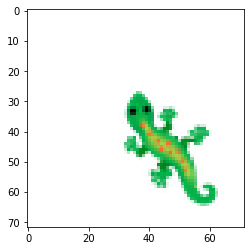

training:  60%|██████    | 6/10 [05:15<03:30, 52.60s/it]

epoch 6, step 0
epoch 6, step 1
epoch 6, step 2
epoch 6, step 3
epoch 6, step 4
epoch 6, step 5
epoch 6, step 6
epoch 6, step 7
epoch 6, step 8
epoch 6, step 9
epoch 6, step 10
epoch 6, step 11
epoch 6, step 12
epoch 6, step 13
epoch 6, step 14
epoch 6, step 15
epoch 6, step 16
epoch 6, step 17
epoch 6, step 18
epoch 6, step 19
epoch 6, step 20
epoch 6, step 21
epoch 6, step 22
epoch 6, step 23
epoch 6, step 24
epoch 6, step 25
epoch 6, step 26
epoch 6, step 27
epoch 6, step 28
epoch 6, step 29


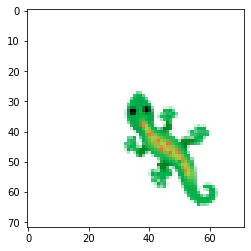

training:  70%|███████   | 7/10 [06:07<02:37, 52.57s/it]

epoch 7, step 0
epoch 7, step 1
epoch 7, step 2
epoch 7, step 3
epoch 7, step 4
epoch 7, step 5
epoch 7, step 6
epoch 7, step 7
epoch 7, step 8
epoch 7, step 9
epoch 7, step 10
epoch 7, step 11
epoch 7, step 12
epoch 7, step 13
epoch 7, step 14
epoch 7, step 15
epoch 7, step 16
epoch 7, step 17
epoch 7, step 18
epoch 7, step 19
epoch 7, step 20
epoch 7, step 21
epoch 7, step 22
epoch 7, step 23
epoch 7, step 24
epoch 7, step 25
epoch 7, step 26
epoch 7, step 27
epoch 7, step 28
epoch 7, step 29


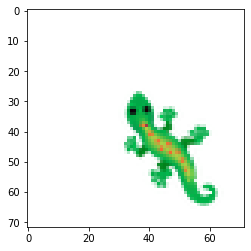

training:  80%|████████  | 8/10 [07:00<01:45, 52.54s/it]

epoch 8, step 0
epoch 8, step 1
epoch 8, step 2
epoch 8, step 3
epoch 8, step 4
epoch 8, step 5
epoch 8, step 6
epoch 8, step 7
epoch 8, step 8
epoch 8, step 9
epoch 8, step 10
epoch 8, step 11
epoch 8, step 12
epoch 8, step 13
epoch 8, step 14
epoch 8, step 15
epoch 8, step 16
epoch 8, step 17
epoch 8, step 18
epoch 8, step 19
epoch 8, step 20
epoch 8, step 21
epoch 8, step 22
epoch 8, step 23
epoch 8, step 24
epoch 8, step 25
epoch 8, step 26
epoch 8, step 27
epoch 8, step 28
epoch 8, step 29


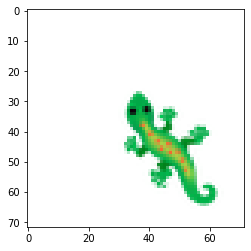

training:  90%|█████████ | 9/10 [07:52<00:52, 52.53s/it]

epoch 9, step 0
epoch 9, step 1
epoch 9, step 2
epoch 9, step 3
epoch 9, step 4
epoch 9, step 5
epoch 9, step 6
epoch 9, step 7
epoch 9, step 8
epoch 9, step 9
epoch 9, step 10
epoch 9, step 11
epoch 9, step 12
epoch 9, step 13
epoch 9, step 14
epoch 9, step 15
epoch 9, step 16
epoch 9, step 17
epoch 9, step 18
epoch 9, step 19
epoch 9, step 20
epoch 9, step 21
epoch 9, step 22
epoch 9, step 23
epoch 9, step 24
epoch 9, step 25
epoch 9, step 26
epoch 9, step 27
epoch 9, step 28
epoch 9, step 29


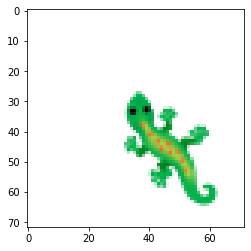

training: 100%|██████████| 10/10 [08:45<00:00, 52.54s/it]


In [56]:
#@title Training { vertical-output: true}

# TODO add the Zero training input output? --> check NUM_TOKENS amount

# training
log_loss = []
UPDATE_STEPS = 30
EVAL_SENTENCE_BATCH = 32

# X - 4d tensor - maybe move this
def get_input_values(x):
  step_output_float_mask = get_dilatied_mask(x).to(device)

  # X values
  percieved_images = percieve(x)
  X_img = percieved_images[0]

  X_seq_un_clean = image_to_sentences(X_img)
  # TODO - insert checker as torch.tensor(X_seq_un_clean).bool().float().sum(dim=-1)
  valid_instances = (torch.square(X_seq_un_clean).sum(dim=-1) != 0).nonzero().flatten()

  X_seq_cleaned = X_seq_un_clean[valid_instances]

  X_seq = tokenize(X_seq_cleaned)

  return step_output_float_mask, valid_instances, X_seq


# 1 epoch. training from seed to 'full' state.
for i in tqdm.tqdm(range(EPOCHS), mininterval=10., desc='training'):
    x0 = np.repeat(seed[None,...], IMAGE_BATCH_SIZE, 0)
    x0 = torch.Tensor(x0).to(device)
    x = x0
    
    for step in range(UPDATE_STEPS):
      print(f'epoch {i}, step {step}')

      step_output_float_mask, valid_instances, X_seq = get_input_values(x)

      # target 
      y_target = mask_target(step_output_float_mask.bool().float())[0]

      # Prefix
      prefix = get_start_tokens(X_seq.shape[0])

      # Y valyes from target
      y_seq_un_cleaned = image_to_sentences(y_target)
      y_seq_cleaned = y_seq_un_cleaned[valid_instances]
      y_seq = tokenize(y_seq_cleaned)
      Y_seq = torch.cat([prefix, X_seq, y_seq], 1)

      # Derive dataset for training.
      dataset = CellTraining(X_seq, Y_seq)

      data_loader = DataLoader(dataset=dataset, batch_size=32)
            
      enc.train(), dec.train()
      for batch_i , (src, tgt, src_mask, tgt_mask) in enumerate(data_loader):
        context = enc(src, input_mask = src_mask)
        loss = dec(tgt, context = context, input_mask = tgt_mask, context_mask = src_mask, return_loss = True)
        loss.backward()
        # print(f'epoch-{i}-step-{step}: {loss.item()}')
        optim.step()
        optim.zero_grad()

      # update what x is (the target dilated & alive tgt mask)
      x = mask_target(step_output_float_mask.bool().float()).to(device)

    # Generate:
    # TODO - define what x is? x[0] ? 
    # Make an evaluation function which returns values?
    enc.eval(), dec.eval()
    # x = x0.detach().clone()
    for step in range(10):
      output_seq = image_to_sentences(x[0]).long()

      step_output_float_mask, instances, X_seq = get_input_values(x)

      dataset = CellEvaluating(X_seq)
      data_loader = DataLoader(dataset=dataset, batch_size=EVAL_SENTENCE_BATCH, shuffle=False)
      
      generated= torch.empty(size=(X_seq.shape[0], CHANNEL_N)).long().to(device)

      for batch_i , (src, src_mask) in enumerate(data_loader):
        start_tokens = (torch.ones((src.shape[0], 1)) * 1).long().to(device)

        context = enc(src)
        # Are these params correct
        sample = dec.generate(start_tokens, CHANNEL_N , context = context)
        predicted_cells = sample[:, - CHANNEL_N: ]
        s = batch_i*EVAL_SENTENCE_BATCH
        # print(predicted_cells)
        generated[torch.arange(s,s+predicted_cells.shape[0])] = predicted_cells

      output_seq[instances] = detokenize(generated)
      output_img = sentences_to_image(output_seq, x.shape[2], x.shape[3])
      x = output_img[None,...]
    visualize_batched(x.detach().clone())

      
    # TODO - produced x - calculate l2 loss and add to log loss